In [16]:
from __future__ import absolute_import, division, print_function
import tensorflow as tf
from tensorflow import keras
import matplotlib.pyplot as plt
import numpy as np
import cv2
import os
import re

IMAGE_WIDTH = 400
IMAGE_HEIGHT = 5000
TRAIN_DATA_DIR = "Trimed_graphite_Images\\Train"
TEST_DATA_DIR = "Trimed_graphite_Images\\Test"
FACE_INSIDE = 0
FACE_OUTSIDE = 1
CYCLENO_NORMALIZE = 100
EPOCHS = 500000
NUMBER_OF_LABELS = 3

In [9]:
# Feature extraction functions
# 1. Average pixel value
# 2. Average pixel sd
# 3 - 5. Average R/G/B value
# 6 - 8. R/G/B sd
# 9 - 10. Fraction of light/dark RGB values (over 1 sd)
# 11 - 12. Fraction of very light/dark RGB values (over 3 sd)

# extensions: k-means clustering to get representative colors and proportions, positions of clusters? hsv representation?

def extractFeatures(im):
    mean, sd = cv2.meanStdDev(im) # 3 - 5, 6 - 8
    
    pixVals = im.sum(axis=2)
    avgPixVal = pixVals.mean() # 1
    sdPixVal = pixVals.flatten().std() # 2
    
    '''
    avgVals = im.mean(axis=0).mean(axis=0) # [avg R, avg G, avg B] (2 - 4)
    avgPixelVal = avgVals.mean() # avg pixel val (1)
    '''
    
    lightCount = 0 # 9
    darkCount = 0 # 10
    vlightCount = 0 # 11
    vdarkCount = 0 # 12
    for x in range(pixVals.shape[1]):
        for y in range(pixVals.shape[0]):
            if pixVals[y][x] > avgPixVal + 1 * sdPixVal:
                lightCount = lightCount + 1
            if pixVals[y][x] < avgPixVal - 1 * sdPixVal:
                darkCount = darkCount + 1
            if pixVals[y][x] > avgPixVal + 3 * sdPixVal:
                vlightCount = vlightCount + 1
            if pixVals[y][x] < avgPixVal - 3 * sdPixVal:
                vdarkCount = vdarkCount + 1
            
    features = [avgPixVal, sdPixVal, mean[0], mean[1], mean[2], sd[0], sd[1], sd[2], 
                lightCount/(pixVals.shape[0]*pixVals.shape[1]), darkCount/(pixVals.shape[0]*pixVals.shape[1]),
                vlightCount/(pixVals.shape[0]*pixVals.shape[1]), vdarkCount/(pixVals.shape[0]*pixVals.shape[1])]
    return np.array(features).astype(np.float32)
            

In [10]:
# Import data and extract features
def importData(directory):
    iteration = 1
    print("Importing data from " + directory + "...")
    
    for filename in os.listdir(directory):
        # import image
        im = cv2.imread(directory + "\\" + filename)
        print("  " + filename)
        resized_im = cv2.resize(im, (IMAGE_WIDTH, IMAGE_HEIGHT))
        
        # import labels [dischargeC, chargeC, cycleNo, face]
        conditions, barcode, face = filename.split("_")
        match = re.search(r'(\d*)c(\d*)c(\d*)cycles', conditions)
        face_bool = FACE_INSIDE if face == "inside" else FACE_OUTSIDE
        agg = [float(match.group(1)), float(match.group(2)), float(match.group(3))/CYCLENO_NORMALIZE]
        agg = np.asarray(agg, dtype=np.float32)
        # ignore face of electrode for now
        # agg = [match.group(1), match.group(2), match.group(3), face_bool]
                        
        # assemble features and labels
        if iteration == 1:
            data = extractFeatures(resized_im)
            labels = agg
        else:
            data = np.vstack((data, extractFeatures(resized_im)))
            labels = np.vstack((labels, agg))
        iteration = iteration + 1
        
    return data, labels


# Load training and test data
train_data, train_labels = importData(TRAIN_DATA_DIR)
test_data, test_labels = importData(TEST_DATA_DIR)

Importing data from Trimed_graphite_Images\Train...
  3c3c150cycles_12994_outside.jpg
  3c4c1000cycles_12142_inside.jpg
  3c4c1000cycles_12142_outside.jpg
  3c4c400cycles_17917_inside.jpg
  3c4c400cycles_17917_outside.jpg
  3c4c800cycles_47450_inside.jpg
  3c5c100cycles_25898_inside.jpg
  3c5c100cycles_25898_outside.jpg
  3c5c200cycles_24375_outside.jpg
  3c6c100cycles_27668_inside.jpg
  3c6c100cycles_27668_outside.jpg
  3c6c250cycles_16375_outside.jpg
  3c7c200cycles_25606_inside.jpg
  3c7c200cycles_25606_outside.jpg
  3c8c200cycles_47446_inside.jpg
  3c8c200cycles_47446_outside.jpg
  3c8c300cycles_10808_outside.jpg
  4c4c1000cycles_38369_inside.jpg
  4c5c1000cycles_13520_inside.jpg
  4c5c1000cycles_13520_outside.jpg
  4c6c1000cycles_21042_outside.jpg
  5c3c100cycles_25684_inside.jpg
  5c3c100cycles_25684_outside.jpg
  5c3c200cycles_19741_outside.jpg
  5c4c1000cycles_26293_inside.jpg
  5c4c1000cycles_26293_outside.jpg
  6c4c200cycles_11008_outside.jpg
  6c4c300cycles_40867_inside.jpg


In [11]:
# Normalize features
# Test data is *not* used when calculating the mean and std

mean = train_data.mean(axis=0)
std = train_data.std(axis=0)
train_data = (train_data - mean) / std
test_data = (test_data - mean) / std
print("Training set: {}".format(train_data.shape))
print("Testing set:  {}".format(test_data.shape))

Training set: (32, 12)
Testing set:  (10, 12)


In [37]:
# Build model
model = keras.Sequential([
    keras.layers.Dense(64, activation=tf.nn.relu,
                       input_shape=(train_data.shape[1],)),
    keras.layers.Dense(64, activation=tf.nn.relu),
    keras.layers.Dense(3)
])

optimizer = tf.train.RMSPropOptimizer(0.001)

model.compile(loss='mae', optimizer=optimizer, metrics=['mae'])
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_12 (Dense)             (None, 64)                832       
_________________________________________________________________
dense_13 (Dense)             (None, 64)                4160      
_________________________________________________________________
dense_14 (Dense)             (None, 3)                 195       
Total params: 5,187
Trainable params: 5,187
Non-trainable params: 0
_________________________________________________________________


In [2]:
# Train model
# Display training progress by printing a single dot for each completed epoch
class PrintDot(keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs):
    if epoch % int(EPOCHS/5) == 0: print('')
    if epoch % int(EPOCHS/500) == 0:print('.', end='')

# Plotting
def plot_history(history):
  plt.figure()
  plt.xlabel('Epoch')
  plt.ylabel('Mean Absolute Error')
  plt.plot(history.epoch, np.array(history.history['mean_absolute_error']),
           label='Train Loss')
  plt.legend()
  plt.ylim([0, 0.01])

history = model.fit(train_data, train_labels, epochs=EPOCHS, verbose=0, callbacks=[PrintDot()])
plot_history(history)

NameError: name 'keras' is not defined


Testing set Mean Squared Error: 1.0826


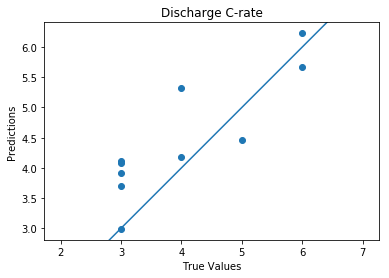

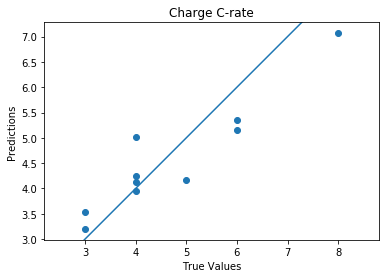

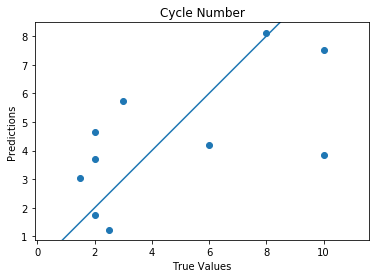

In [39]:
# Test results
[loss, mae] = model.evaluate(test_data, test_labels, verbose=0)

print("\nTesting set Mean Squared Error: {:2.4f}".format(mae))

# Predictions using test set
test_predictions = model.predict(test_data)
labels = ['Discharge C-rate', 'Charge C-rate', 'Cycle Number']

for labelI in range(NUMBER_OF_LABELS):
    plt.figure()
    plt.scatter(test_labels[:, labelI], test_predictions[:, labelI])
    plt.xlabel('True Values')
    plt.ylabel('Predictions')
    plt.title(labels[labelI])
    plt.axis('equal')
    plt.xlim(plt.xlim())
    plt.ylim(plt.ylim())
    _ = plt.plot([-10, 10], [-10, 10])

In [1]:
error = test_predictions.flatten() - test_labels.flatten()
plt.hist(error, bins = 10)
plt.xlabel("Prediction Error")
_ = plt.ylabel("Count")

NameError: name 'test_predictions' is not defined